<a href="https://colab.research.google.com/github/zrosen3/Colombian-peso-counterfeit-detection/blob/main/Code/log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries

In [2]:
#Set up google colab working environment
!pwd
!pip install tensorflow_decision_forests
!git clone https://github.com/zrosen3/Colombian-peso-counterfeit-detection.git 
%cd /content/Colombian-peso-counterfeit-detection/Code       
!pwd      

/content
Cloning into 'Colombian-peso-counterfeit-detection'...
remote: Enumerating objects: 21078, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 21078 (delta 59), reused 62 (delta 24), pack-reused 20965
Receiving objects: 100% (21078/21078), 440.16 MiB | 24.85 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Updating files: 100% (62416/62416), done.
/content/Colombian-peso-counterfeit-detection/Code
/content/Colombian-peso-counterfeit-detection/Code


In [5]:
import matplotlib.pyplot as plt #For plotting our visualizations
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow_decision_forests as tfdf
import cv2
from PIL import Image
import seaborn as sns
import common_functions as cf


#Load in data

In [6]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData()


Found 12479 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.


## Run logistic regression model

In [11]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(480, 640, 3)),
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(
                units = 13,
               activation = "softmax"
        )])
        
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=5)

Epoch 1/5
390/390 [==============================] - 208s 511ms/step - loss: 33.6813 - accuracy: 0.5299 - val_loss: 6.3775 - val_accuracy: 0.7637
Epoch 2/5
390/390 [==============================] - 196s 501ms/step - loss: 12.5541 - accuracy: 0.7489 - val_loss: 8.1899 - val_accuracy: 0.8127
Epoch 3/5
390/390 [==============================] - 227s 582ms/step - loss: 13.4866 - accuracy: 0.7800 - val_loss: 6.3529 - val_accuracy: 0.8425
Epoch 4/5
390/390 [==============================] - 185s 472ms/step - loss: 7.3319 - accuracy: 0.8514 - val_loss: 3.6934 - val_accuracy: 0.9014
Epoch 5/5
390/390 [==============================] - 187s 477ms/step - loss: 4.3386 - accuracy: 0.8924 - val_loss: 3.0362 - val_accuracy: 0.9163


## Inspect model performance

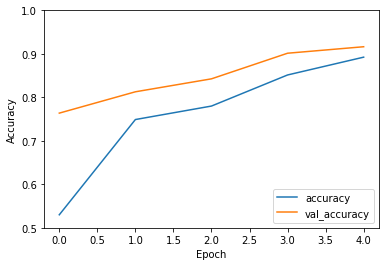

130/130 - 26s - loss: 2.5940 - accuracy: 0.9216 - 26s/epoch - 198ms/step
Test loss: 2.5939769744873047 | Test accuracy: 0.9216346144676208


In [12]:
cf.EvaluateModel(model, test_ds, history)